## Домашнее задание: "Детекция объектов на изображении"

ФИО:

## Цель задания:
Научиться самостоятельно решать задачу детекции.
## Описание задания:
В рамках данного домашнего задания предлагается решить задачу детекции мячей и настроить полный пайплайн обучения модели.

Процесс выполнения задания следующий:

0. Выбор модели детекции для обучения:
    1. Выберите модель детекции для выполнения домашнего задания. Любую, кроме RetinaNet. Ее реализацию можно взять из открытых источников. Модель можно брать предобученную ( в этом случае в пункте 4. показать влияние предобучения на финальное качество).
    2. Полезные ссылки: [PyTorch Vision Models](https://pytorch.org/vision/stable/models.html) (блок Object Detection), [SOTA модели детекции](https://paperswithcode.com/sota/object-detection-on-coco), [Возможный пример кода](https://github.com/AlekseySpasenov/dl-course/blob/autumn_2023/lecture8/detection_example/pytorch_detection_workshop.ipynb)
    3. Вы можете использовать RetinaNet, которая была реализована на семинаре, но это приведет к снижению оценки на **–2.5 балла**, так как задания 1.1 и 2.1 уже были выполнены в рамках занятия.

1. Подготовка обучающего набора данных
    0. Для выполнения задания используйте датасет с изображениями мячей, который использовался на семинаре.
    1. Реализуйте корректный класс Dataset и Dataloader для выбранной модели (должен работать форвард вашей модели на том, что выходит из даталоадера) **0.5 балла**.
    2. Добавьте простые аугментации в датасет (аугментации, не затрагивающие изменение ground-truth bounding box) **0.5 балла**.
    3. Внедрите сложные аугментации (аугментации, затрагивающие изменение ground-truth bounding box. Например, аффинные преобразования: сдвиг, поворот и т.д.) **0.5 балла**.

    4. Полезные ссылки: https://pytorch.org/vision/stable/transforms.html , https://albumentations.ai

2. Реализация корректного train-loop и обучение модели:  
    1. Реализуйте эффективный train-loop для вашей модели и проведите обучение **2 балла**.
    2. Выполните несколько запусков обучения с различными параметрами, например: сравните влияние различных аугментаций, оцените влияние того была предобучена модель или нет, сравните результаты при изменении гиперпараметров итд (на ваш выбор) **0.5 балла**.

3. Валидация обученных моделей на тестовой выборке, вычисление метрики mAP
    1. Оцените качество моделей на тестовой части данных и рассчитайте метрику mAP **0.5 балл**
    2. Полезные ссылки: [mean_average_precision](https://github.com/bes-dev/mean_average_precision)

4. Выводы **0.5 балл**:
    1. Проанализируйте результаты обучения, визуально оцените качество работы модели.
    2. Прокомментируйте распространенные ошибки модели и предложите пути для улучшения финального решения.

#Основной пайплайн

##Загрузка данных

In [1]:
!gdown "https://drive.google.com/uc?id=1ZMPIHcEVOZx9OukDOGvmkndkVGYpmIEF" -O seminar_objdet_retina_oi5_ball.zip

Downloading...
From (original): https://drive.google.com/uc?id=1ZMPIHcEVOZx9OukDOGvmkndkVGYpmIEF
From (redirected): https://drive.google.com/uc?id=1ZMPIHcEVOZx9OukDOGvmkndkVGYpmIEF&confirm=t&uuid=0452a07a-0c73-4b9d-b513-f83309a66953
To: /content/seminar_objdet_retina_oi5_ball.zip
100% 1.08G/1.08G [00:07<00:00, 138MB/s]


In [2]:
!unzip seminar_objdet_retina_oi5_ball.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/2688.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._2688.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/1381.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._1381.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/0921.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._0921.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/0909.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._0909.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/3025.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._3025.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/1626.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._1626.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/0538.jpg  
  inflating: __MACOSX/seminar_objd

## Выбор модели

В качестве рабочей модели выберем Faster R-CNN, backbone которой представляет из себя ResNet-50. Также модель содержит FPN для учета локальных и глобальных активаций

In [29]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 22.2 MB/s eta 0:00:00


In [30]:
import torch
import torchvision
import torchmetrics
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
import json
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 176MB/s]


Заменим классификатор модели на "чистый" необученный классификатор с двумя выходам (мячи и фон)

In [6]:
num_classes = 2

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

##Подготовка данных

Определим класс BallDataset для корректной обработки изображений и соответствующих им bounding box'ов

In [7]:
class BallDataset(Dataset):
    def __init__(self, data_dict_file, add_path="./", transforms=None):
        with open(data_dict_file, 'r') as f:
            self.data_dict = json.load(f)
        self.imgs = list(self.data_dict.keys())
        self.add_path = add_path
        self.transforms = transforms

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img_path = os.path.join(self.add_path, img_name)
        image = Image.open(img_path).convert("RGB")
        w, h = image.size

        boxes = []
        for b in self.data_dict[img_name]: # Формат bbox'в json'е: xmin, xmax, ymin, ymax, что не является pascal_voc форматом
            xmin = b[0] * w
            ymin = b[2] * h
            xmax = b[1] * w
            ymax = b[3] * h
            if xmax > xmin and ymax > ymin:
                boxes.append([xmin, ymin, xmax, ymax])
        labels = [1] * len(boxes)

        image_np = np.array(image)

        if self.transforms:
            transformed = self.transforms(image=image_np, bboxes=boxes, labels=labels)
            image = transformed["image"]
            boxes = transformed["bboxes"]
            labels = transformed["labels"]

        # После транформаций bbox может оказаться за пределами изображения, в этом случае он будет удален
        # и тогда на вход сети поступит изображение без bbox'ов. На таком примере сеть не сможет обучиться,
        # поэтому требуется его убрать
        if len(boxes) == 0:
            return None

        boxes_tensor = torch.as_tensor(boxes, dtype=torch.float32)
        labels_tensor = torch.as_tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes_tensor, "labels": labels_tensor}
        return image, target

Теперь можно определить аугментации к данным

In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [10]:
train_transforms = A.Compose([
    A.Resize(512, 512),

    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.ShiftScaleRotate(
        shift_limit=0.05, scale_limit=0.1, rotate_limit=5,
        border_mode=0, value=(0, 0, 0), p=0.7
    ),

    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.4),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.3),
    A.Blur(blur_limit=3, p=0.2),
    A.RandomGamma(p=0.3),

    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
],
bbox_params=A.BboxParams(
    format='pascal_voc',
    label_fields=['labels'],
    min_visibility=0.2,  # Отсекаем боксы, которые почти полностью вышли за пределы
))

val_transforms = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
],
bbox_params=A.BboxParams(
    format='pascal_voc',
    label_fields=['labels'],
))

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-1502270981.py:7: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(


Создадим датасеты и даталоадеры

In [11]:
def collate_fn(batch):
    batch = [b for b in batch if b is not None] # Некоторые значения в батче могут быть None, поэтому нужно учесть только не пустые элементы
    if len(batch) == 0: # Если вдруг все значения в батче оказались пустыми, тогда считаем, что батч пустой
        return [], []
    return tuple(zip(*batch))

In [12]:
train_dataset = BallDataset(
    data_dict_file="./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_train.json",
    add_path="./seminar_objdet_retina_oi5_ball/",
    transforms=train_transforms
)

val_dataset = BallDataset(
    data_dict_file="./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_val.json",
    add_path="./seminar_objdet_retina_oi5_ball/",
    transforms=val_transforms
)

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          collate_fn=collate_fn, num_workers=0)


val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                          collate_fn=collate_fn, num_workers=0)

Визуализируем несколько семплов из тренировочного и валидационного наборов данных

In [13]:
def visualize_sample(image, target, figsize=(6,6), box_color=(255,0,0), box_thickness=2):
    if isinstance(image, torch.Tensor):
        img = image.permute(1,2,0).cpu().numpy()
    else:
        img = np.array(image)

    img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
    img = (img * 255).astype(np.uint8)
    img = img.copy()

    for box in target['boxes']:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), box_color, box_thickness)

    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

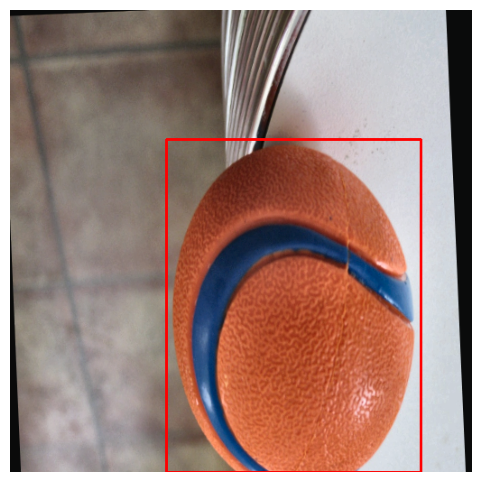

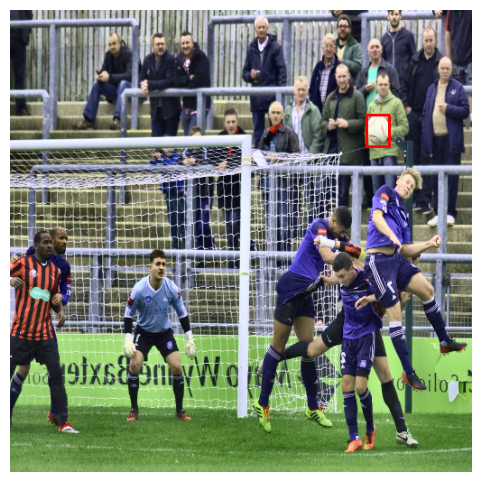

In [14]:
images, targets = next(iter(train_loader))

for i in range(2):
    visualize_sample(images[i], targets[i])

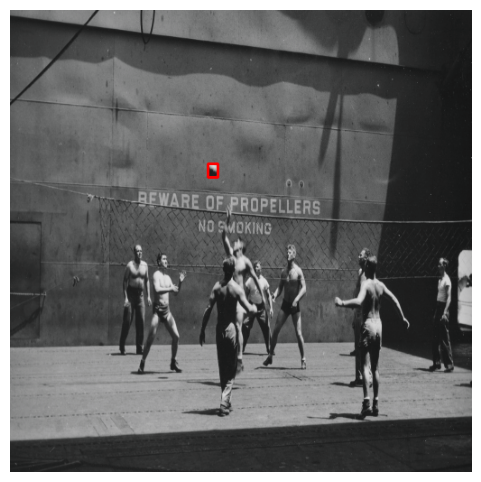

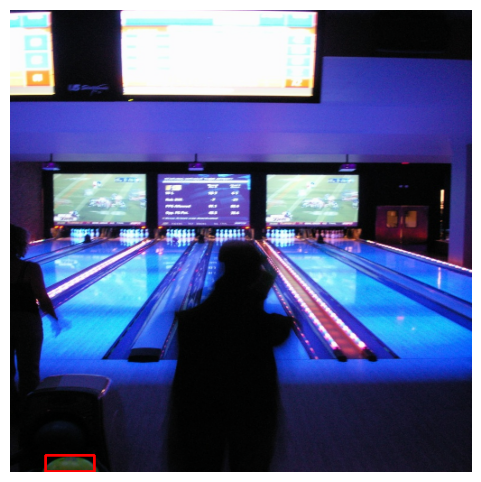

In [15]:
images, targets = next(iter(val_loader))

for i in range(2):
    visualize_sample(images[i], targets[i])

##Дообучение модели

In [16]:
def train_one_epoch(model, optimizer, dataloader, device):
    model.train()
    total_loss = 0.0
    valid_batches = 0  # Считаем только непустые батчи

    pbar = tqdm(dataloader, desc="Training", leave=False)
    for images, targets in pbar:

        # Проверяем пустой ли батч
        if len(images) == 0:
            continue

        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
        valid_batches += 1
        pbar.set_postfix(loss=losses.item())

    # Усредняем по реально использованным батчам
    return total_loss / max(valid_batches, 1)

In [17]:
@torch.no_grad()
def evaluate(model, data_loader, device):
    model.eval()
    total_boxes = 0
    total_images = 0

    for images, targets in tqdm(data_loader, desc="Validation", leave=False):
        images = [img.to(device) for img in images]
        outputs = model(images)

        # Можно посчитать, сколько боксов предсказано (простейшая метрика)
        total_boxes += sum(len(o["boxes"]) for o in outputs)
        total_images += len(images)

    return total_boxes / total_images

In [18]:
def train(model, optimizer, num_epochs, train_loader, val_loader, device):
  losses = []
  means = []
  for epoch in range(num_epochs):
      loss = train_one_epoch(model, optimizer, train_loader, device)
      mean_boxes = evaluate(model, val_loader, device)
      print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {loss:.4f}")

      losses.append(loss)
      means.append(mean_boxes)

  return losses, means

Заморозим все параметры кроме **классификатора**

In [19]:
for param in model.parameters():
    param.requires_grad = False

for param in model.roi_heads.box_predictor.parameters():
    param.requires_grad = True

Теперь все готово к обучению

In [20]:
num_epochs = 10
lr = 1e-4

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=lr, weight_decay=1e-4)

In [21]:
losses, means = train(model, optimizer, num_epochs, train_loader, val_loader, device)

Epoch [1/10]  Loss: 0.4462


Epoch [2/10]  Loss: 0.4194


Epoch [3/10]  Loss: 0.4086


Epoch [4/10]  Loss: 0.4063


Epoch [5/10]  Loss: 0.4045


Epoch [6/10]  Loss: 0.4039


Epoch [7/10]  Loss: 0.4053


Epoch [8/10]  Loss: 0.4038


Epoch [9/10]  Loss: 0.4014


Epoch [10/10]  Loss: 0.4032


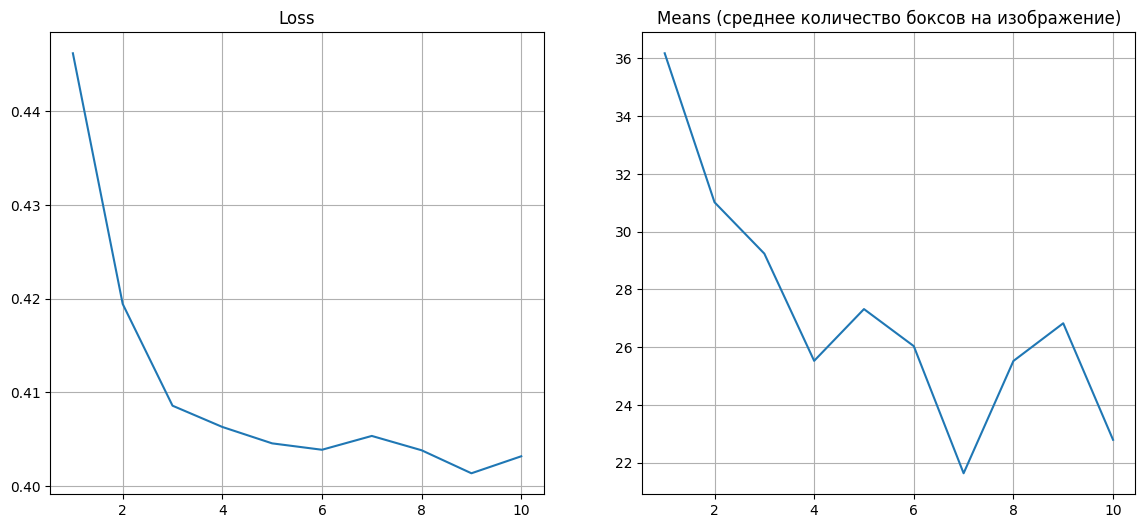

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(np.arange(1, num_epochs + 1), losses)
axs[0].set_title('Loss')
axs[0].grid()

axs[1].plot(np.arange(1, num_epochs + 1), means)
axs[1].set_title('Means (среднее количество боксов на изображение)')
axs[1].grid()

## Оценка

Для начала сравним предсказанные боксы с разметкой визуально

In [22]:
def visualize_sample_and_prediction(image, sample_target, pred_target, figsize=(12,6), box_color=(255,0,0), box_thickness=2):
    """
    Показывает изображение с bounding boxes.

    image: torch.Tensor (C,H,W)
    target: dict с ключами 'boxes' и 'labels'
    """
    if isinstance(image, torch.Tensor):
        img = image.permute(1,2,0).cpu().numpy()
    else:
        img = np.array(image)

    img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
    img = (img * 255).astype(np.uint8)
    img1 = img.copy()
    img2 = img.copy()

    for box in sample_target['boxes']:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img1, (x1, y1), (x2, y2), box_color, box_thickness)

    for box in pred_target['boxes']:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img2, (x1, y1), (x2, y2), box_color, box_thickness)

    fig, axs = plt.subplots(1, 2, figsize=figsize)
    axs[0].imshow(img1)
    axs[0].axis('off')
    axs[0].set_title('ground truth')

    axs[1].imshow(img2)
    axs[1].axis('off')
    axs[1].set_title('prediction')

    plt.show()

In [23]:
val_iter = iter(val_loader)
images, targets = next(val_iter)
images = [img.to(device) for img in images]

model.eval()
with torch.no_grad():
    predictions = model(images)

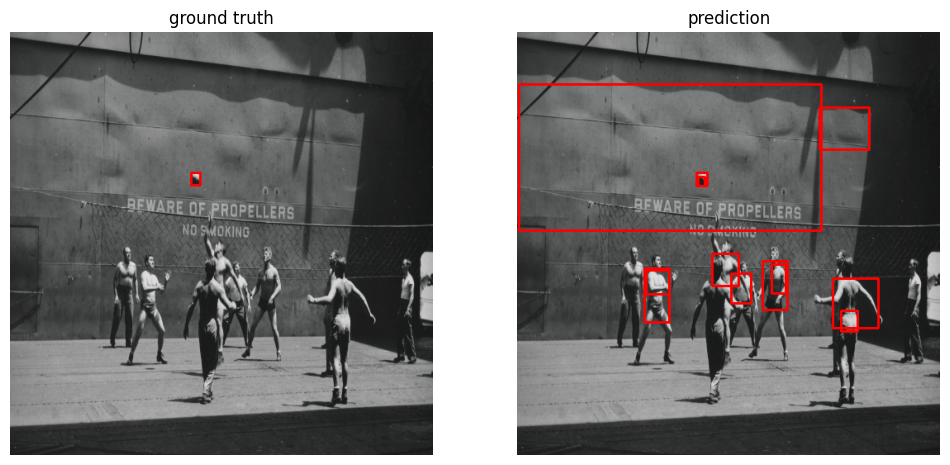

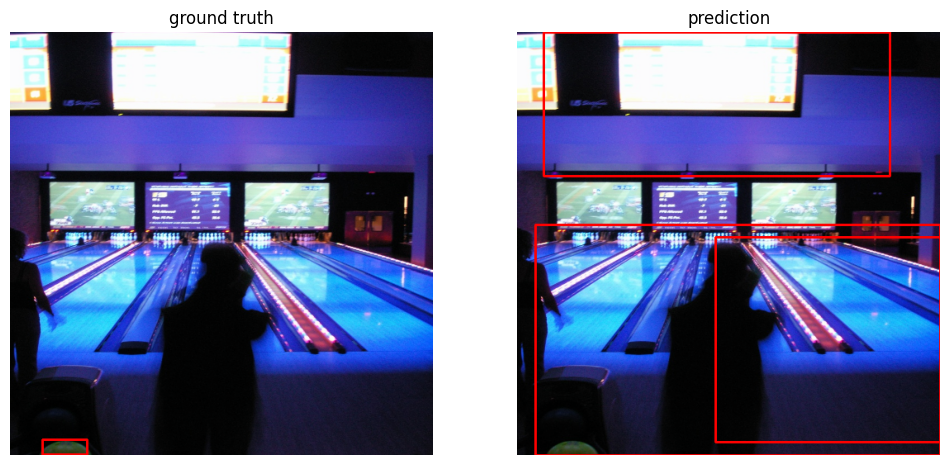

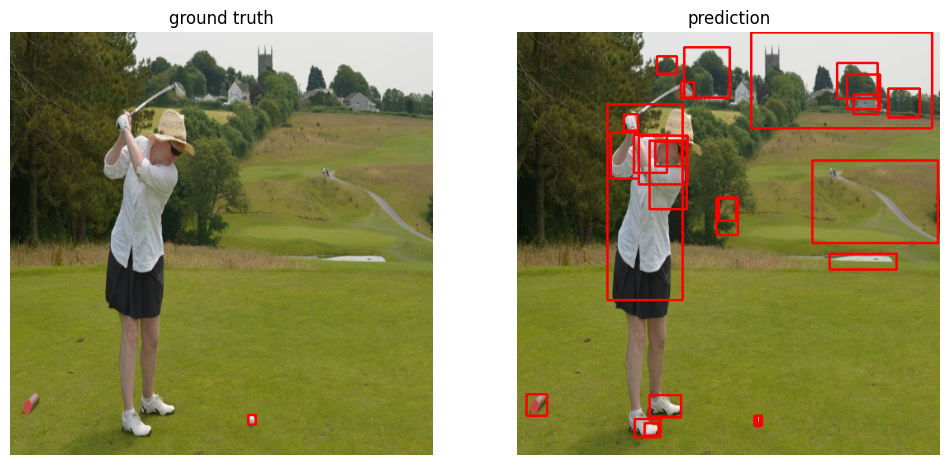

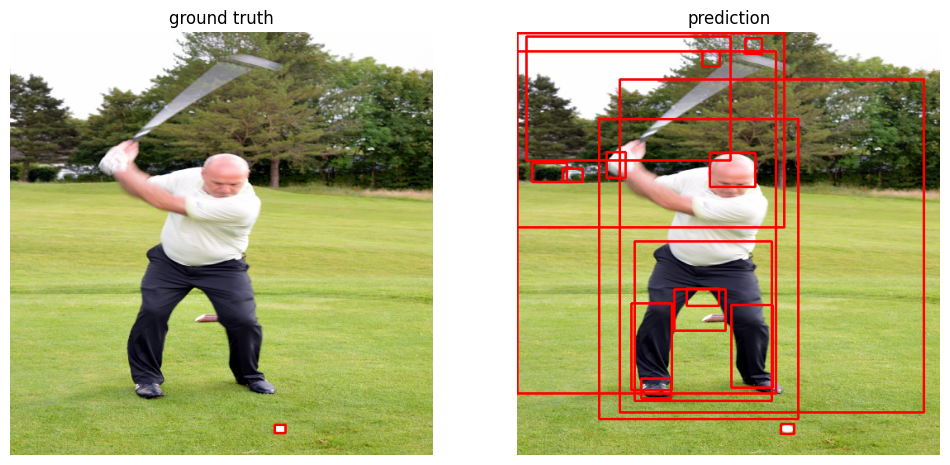

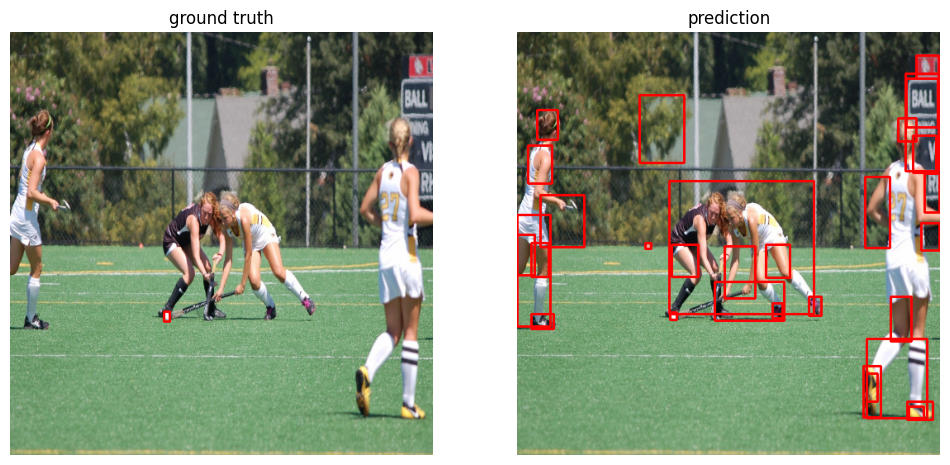

In [24]:
for i in range(5):
    visualize_sample_and_prediction(images[i], targets[i], predictions[i])

Получим предсказания для всей валидационной выборки

In [26]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, targets in tqdm(val_loader, desc="Evaluating"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

        preds = model(images)

        all_preds.extend(preds)
        all_targets.extend(targets)

Evaluating: 100%|██████████| 29/29 [00:21<00:00,  1.36it/s]


И посчитаем mAP (в данном случае это просто AP, т.к. имеется всего один класс)

In [31]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

map_metric = MeanAveragePrecision(iou_thresholds=[0.5], class_metrics=True)

In [32]:
formatted_preds = []
formatted_targets = []

for pred, tgt in zip(all_preds, all_targets):
    # Предсказания
    formatted_preds.append({
        "boxes": pred["boxes"].cpu(),
        "scores": pred["scores"].cpu(),
        "labels": pred["labels"].cpu()
    })
    # Ground truth
    formatted_targets.append({
        "boxes": tgt["boxes"].cpu(),
        "labels": tgt["labels"].cpu()
    })


In [33]:
map_metric.update(formatted_preds, formatted_targets)
result = map_metric.compute()

print("mAP:", result['map'].item())

mAP: 0.3465256989002228


#Попытка стать лучше


##Модель

In [40]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [41]:
num_classes = 2

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [42]:
print("score_thresh:", model.roi_heads.score_thresh)
print("nms_thresh:", model.roi_heads.nms_thresh)

score_thresh: 0.05
nms_thresh: 0.5


score_thresh = 0.05 кажется слишком маленьниким - очень много "мусорных" якорей не отбрасываются из-за низкого score. Так как "мячи" - это единственный класс, который предсказывается и их не так много на изображениях, большое количетсво якорей не отбрасывается в том числе и после NMS (хоть и nms_thresh довольно большой)

Сделаем немного более щадящим NMS, при этом будем отбрасывать больше боксов, содержащих мячи с маленькой вероятностью

In [44]:
model.roi_heads.nms_thresh = 0.3
model.roi_heads.score_thresh = 0.5

print("score_thresh:", model.roi_heads.score_thresh)
print("nms_thresh:", model.roi_heads.nms_thresh)

score_thresh: 0.5
nms_thresh: 0.3


## Аугментации

Так же есть предположение, что аугментации могут быть слишком агрессивными, поэтому внесем некторые изменения. Уменьшим влияние некторых аугментаций и избавимся от ShiftScaleRotate

In [45]:
train_transforms = A.Compose([
    A.Resize(512, 512),

    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),

    A.RandomBrightnessContrast(p=0.3),
    A.HueSaturationValue(p=0.4, hue_shift_limit=10, sat_shift_limit=15),
    A.CLAHE(clip_limit=1.5, tile_grid_size=(8, 8), p=0.3),
    A.RandomGamma(p=0.2),

    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
],
bbox_params=A.BboxParams(
    format='pascal_voc',
    label_fields=['labels'],
    min_visibility=0.2,  # Отсекаем боксы, которые почти полностью вышли за пределы
))

val_transforms = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
],
bbox_params=A.BboxParams(
    format='pascal_voc',
    label_fields=['labels'],
))

## Формирование датасетов

Создадим наборы данных с новыми аугментациями

In [46]:
train_dataset = BallDataset(
    data_dict_file="./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_train.json",
    add_path="./seminar_objdet_retina_oi5_ball/",
    transforms=train_transforms
)

val_dataset = BallDataset(
    data_dict_file="./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_val.json",
    add_path="./seminar_objdet_retina_oi5_ball/",
    transforms=val_transforms
)

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          collate_fn=collate_fn, num_workers=0)


val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                          collate_fn=collate_fn, num_workers=0)

## Дообучение модели

Возможно было бы разумно дообучить некторые другие части сети, а не только классификатор. Однако, для этого требуется много времени и вычислительных ресурсов, которыми на данный момент экспериментатор не обладает. Поэтому так же будем замораживать все слои, кроме классификатора.

In [47]:
for param in model.parameters():
    param.requires_grad = False

for param in model.roi_heads.box_predictor.parameters():
    param.requires_grad = True

Приступим к обучению

In [48]:
num_epochs = 10
lr = 1e-4

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=lr, weight_decay=1e-4)

In [49]:
losses, means = train(model, optimizer, num_epochs, train_loader, val_loader, device)

Epoch [1/10]  Loss: 0.5065


Epoch [2/10]  Loss: 0.4480


Epoch [3/10]  Loss: 0.4395


Epoch [4/10]  Loss: 0.4378


Epoch [5/10]  Loss: 0.4333


Epoch [6/10]  Loss: 0.4315


Epoch [7/10]  Loss: 0.4317


Epoch [8/10]  Loss: 0.4330


Epoch [9/10]  Loss: 0.4306


Epoch [10/10]  Loss: 0.4274


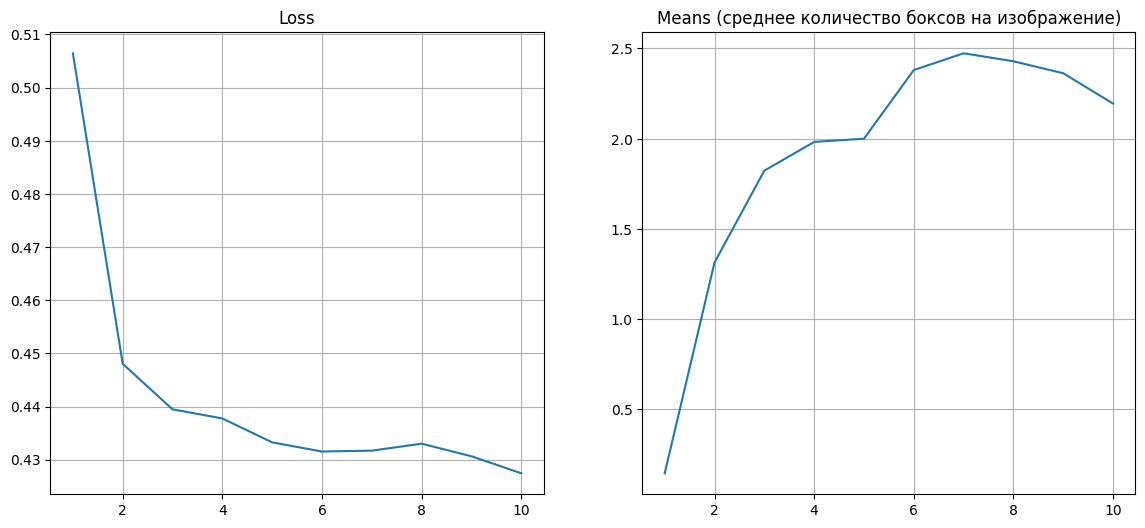

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(np.arange(1, num_epochs + 1), losses)
axs[0].set_title('Loss')
axs[0].grid()

axs[1].plot(np.arange(1, num_epochs + 1), means)
axs[1].set_title('Means (среднее количество боксов на изображение)')
axs[1].grid()

Интересное наблюдение - теперь среднее количество боксов на изображении росло по мере обучения, а не уменьшалось, и стало гораздо меньше по сравнению с опытом с маленьким порогом отсечения боксов.

## Оценка

Так же сначала сравним результаты визуально

In [51]:
val_iter = iter(val_loader)
images, targets = next(val_iter)
images = [img.to(device) for img in images]

model.eval()
with torch.no_grad():
    predictions = model(images)

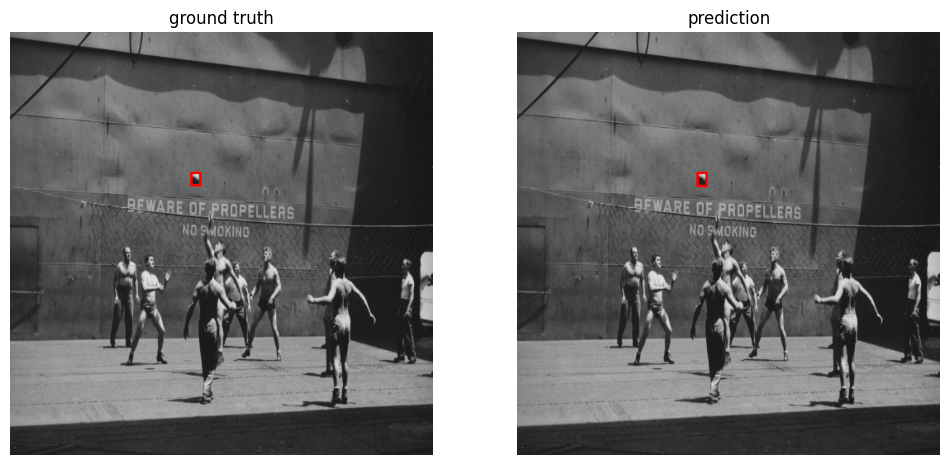

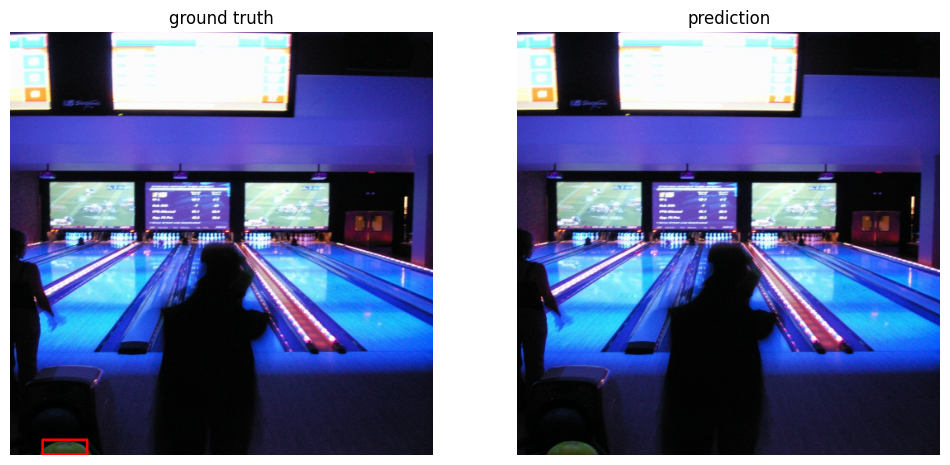

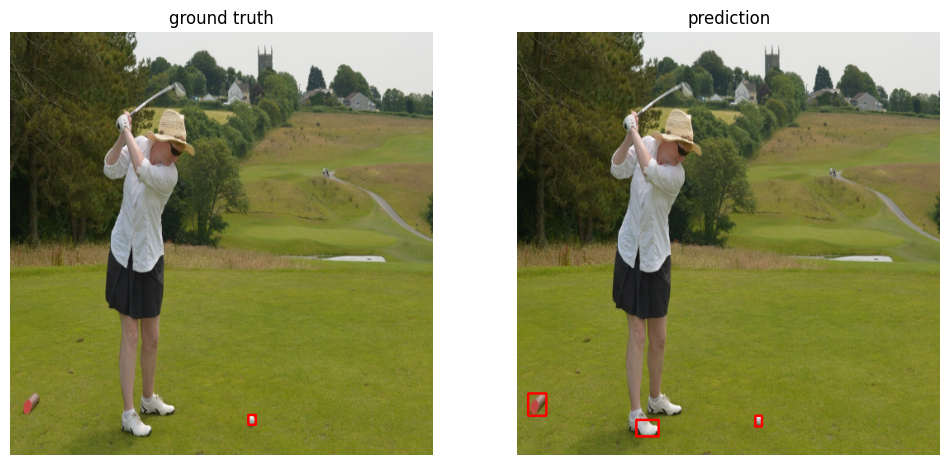

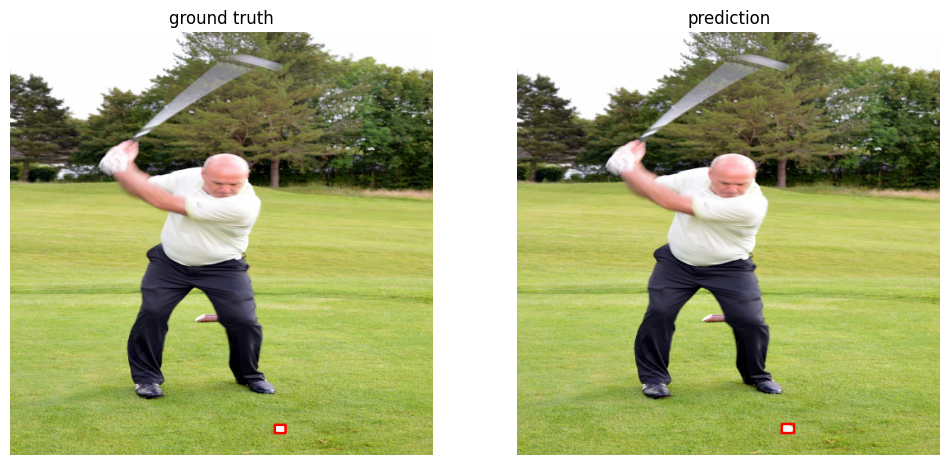

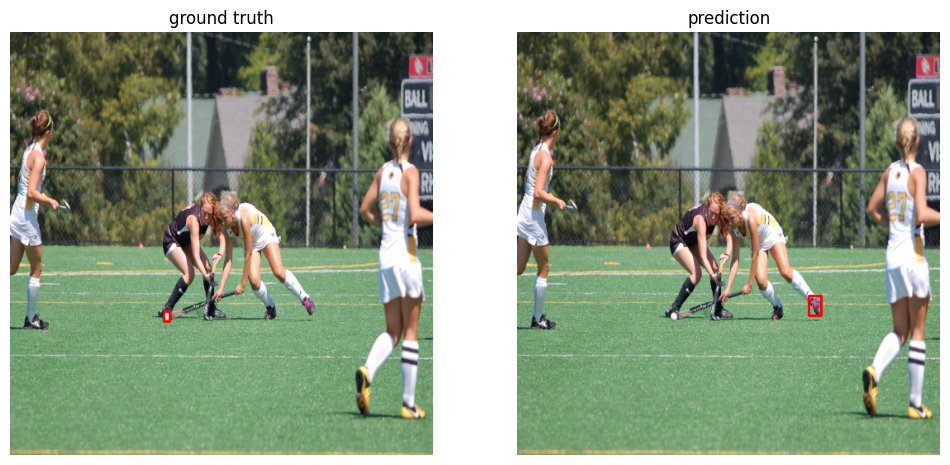

In [52]:
for i in range(5):
    visualize_sample_and_prediction(images[i], targets[i], predictions[i])

Результат далеко не идеальный, но стал на порядок лушче.

In [53]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, targets in tqdm(val_loader, desc="Evaluating"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

        preds = model(images)

        all_preds.extend(preds)
        all_targets.extend(targets)

Evaluating: 100%|██████████| 29/29 [00:21<00:00,  1.37it/s]


Посчитаем mAP

In [54]:
map_metric = MeanAveragePrecision(iou_thresholds=[0.5], class_metrics=True)

In [55]:
formatted_preds = []
formatted_targets = []

for pred, tgt in zip(all_preds, all_targets):
    # Предсказания
    formatted_preds.append({
        "boxes": pred["boxes"].cpu(),
        "scores": pred["scores"].cpu(),
        "labels": pred["labels"].cpu()
    })
    # Ground truth
    formatted_targets.append({
        "boxes": tgt["boxes"].cpu(),
        "labels": tgt["labels"].cpu()
    })


In [56]:
map_metric.update(formatted_preds, formatted_targets)
result = map_metric.compute()

print("mAP:", result['map'].item())

mAP: 0.2750345468521118


#Выводы:

* Выбранная модель - Faster R-CNN, в основе которой лежит ResNet-50 с FPN, с замененным и дообученным классификатором, не показала выдающийся результат по mAP метрике, тем не менее если оценивать результаты визуально, они выглядят довольно достойно.
* Визуально результаты сети из второго эксперимента выглядят лучше, однако значение mAP для неё оказалось ниже. Это объяснимо: при увеличении порога score_thresh уменьшается количество ложноположительных предсказаний, но одновременно часть правильно предсказанных объектов также отбрасывается. В результате повышается Precision, но снижается Recall, и если снижение Recall превышает рост Precision, итоговый mAP уменьшается. Визуальное улучшение во втором случае обусловлено тем, что отображались только предсказания с высокой уверенностью; аналогичного эффекта можно было бы добиться и в первом эксперименте, просто отфильтровав низкоуверенные боксы на этапе визуализации, не изменяя порог внутри модели.
* Есть предположение, что Resize изображений до размеров 224x224 (ImageNet) обеспечил бы FPN более информативными и разнообразными фичами, т.к. backbone это ResNet-50, который проектировался для хорошей работы на ImageNet. Предположительно в этом случае последине слои пирамиды, которые воспринимаются моделью как активации глобальных признаков, не являются таковыми для изображений большего размера.
* Вероятно также помимо обучения чистого классификатора дообучение некторых других частей сети позволило бы достичь более высокого качества.

### Оставьте обратную связь по занятию №6
Это поможет улучшить курс и сделать следующие занятия ещё лучше!
Форма обратной связи: https://forms.gle/hTfRQaGBrqic7LyP6
